# Annotation with CellAssign

## Assigning single-cell RNA-seq data to known cell types

CellAssign is a probabilistic model that uses prior knowledge of cell-type marker genes to annotate scRNA data into predefined cell types. Unlike other methods for assigning cell types, CellAssign does not require labeled single cell data and only needs to know whether or not each given gene is a marker of each cell type. The original paper and R code are linked below.

Paper: [Probabilistic cell-type assignment of single-cell RNA-seq for tumor microenvironment profiling, *Nature Methods 2019*](https://www.nature.com/articles/s41592-019-0529-1 )

Code: https://github.com/Irrationone/cellassign

This notebook will demonstrate how to use CellAssign on follicular lymphoma and HGSC scRNA data.

In [4]:
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]

To demonstrate CellAssign, we use the data from the original publication, which we converted into h5ad format. The data are originally available from here:

https://zenodo.org/record/3372746

In [ ]:
pip install gdown

In [5]:
import gdown
url = 'https://drive.google.com/uc?id=10l6m2KKKioCZnQlRHomheappHh-jTFmx'
output = 'sce_follicular_annotated_final.h5ad'
gdown.download(url, output, quiet=False)

url = 'https://drive.google.com/uc?id=1Pae7VEcoZbKRvtllGAEWG4SOLWSjjtCO'
output = 'sce_hgsc_annotated_final.h5ad'
gdown.download(url, output, quiet=False)

url = 'https://drive.google.com/uc?id=1Mk5uPdnPC4IMRnuG5N4uFvypT8hPdJ74'
output = 'HGSC_celltype.csv'
gdown.download(url, output, quiet=False)

url = 'https://drive.google.com/uc?id=1tJSOI9ve0i78WmszMLx2ul8F8tGycBTd'
output = 'FL_celltype.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=10l6m2KKKioCZnQlRHomheappHh-jTFmx
To: /data/yosef2/users/valehvpa/GitRepos/scvi-tutorials/sce_follicular_annotated_final.h5ad
83.0MB [00:01, 55.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Pae7VEcoZbKRvtllGAEWG4SOLWSjjtCO
To: /data/yosef2/users/valehvpa/GitRepos/scvi-tutorials/sce_hgsc_annotated_final.h5ad
110MB [00:01, 84.9MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1Mk5uPdnPC4IMRnuG5N4uFvypT8hPdJ74
To: /data/yosef2/users/valehvpa/GitRepos/scvi-tutorials/HGSC_celltype.csv
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.16k/1.16k [00:00<00:00, 1.93MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tJSOI9ve0i78WmszMLx2ul8F8tGycBTd
To: /data/yosef2/users/valehvpa/GitRepos/scvi-tutorials/FL_celltype.csv
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

'FL_celltype.csv'

In [6]:
import scvi
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

Global seed set to 0


## Follicular Lymphoma Data

Load follicular lymphoma data and marker gene matrix (see Supplementary Table 2 from the original paper).

In [7]:
adata = sc.read("sce_follicular_annotated_final.h5ad")
adata.var_names_make_unique()
adata.obs_names_make_unique()

/data/yosef2/users/valehvpa/miniconda3/envs/scvi-tools-dev/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [8]:
marker_gene_mat = pd.read_csv('FL_celltype.csv', index_col=0)

### Create and fit CellAssign model

The anndata object and cell type marker matrix should contain the same genes, so we index into `adata` to include only the genes from `marker_gene_mat`.

In [9]:
bdata = adata[:, marker_gene_mat.index].copy()

Then we setup anndata and initialize a `CellAssign` model. Here we set the `size_factor_key` to "size_factor", which is a column in `bdata.obs`. A size factor may be defined manually as scaled library size (total UMI count) and should not be placed on the log scale, as the model will do this manually. The library size should be computed before any gene subsetting (in this case, technically, a few notebook cells up).

For example,

```python
lib_size = adata.X.sum(1)
adata.obs["size_factor"] = lib_size / np.mean(lib_size)
```

In [11]:
scvi.external.CellAssign.setup_anndata(bdata, size_factor_key="size_factor")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 9156 cells, 24 vars, 1 batches, 1 
         labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra  
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [13]:
from scvi.external import CellAssign
model = CellAssign(bdata, marker_gene_mat)
model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Epoch 400/400: 100%|█████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:55<00:00,  7.22it/s, loss=19.9, v_num=1]


Inspecting the convergence:

<AxesSubplot:xlabel='epoch'>

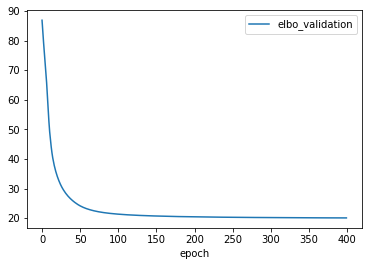

In [14]:
model.history["elbo_validation"].plot()

### Predict and plot assigned cell types

Predict the soft cell type assignment probability for each cell.

In [15]:
predictions = model.predict()
predictions.head()

,B cells,Cytotoxic T cells,CD4 T cells,Tfh,other
0,1.000000e+00,7.236574e-20,6.324416e-16,1.754266e-17,3.476344e-15
1,1.000000e+00,1.092721e-21,7.497309e-18,1.106394e-19,5.981436e-17
2,1.000000e+00,9.595064e-27,9.861875e-23,1.133814e-24,1.078258e-21
3,1.000000e+00,1.139541e-44,8.985825e-38,2.384853e-40,2.626787e-34
4,3.880484e-17,4.667198e-13,9.994294e-01,5.706292e-04,2.487132e-18


We can visualize the probabilities of assignment with a heatmap that returns the probability matrix for each cell and cell type.

/data/yosef2/users/valehvpa/miniconda3/envs/scvi-tools-dev/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


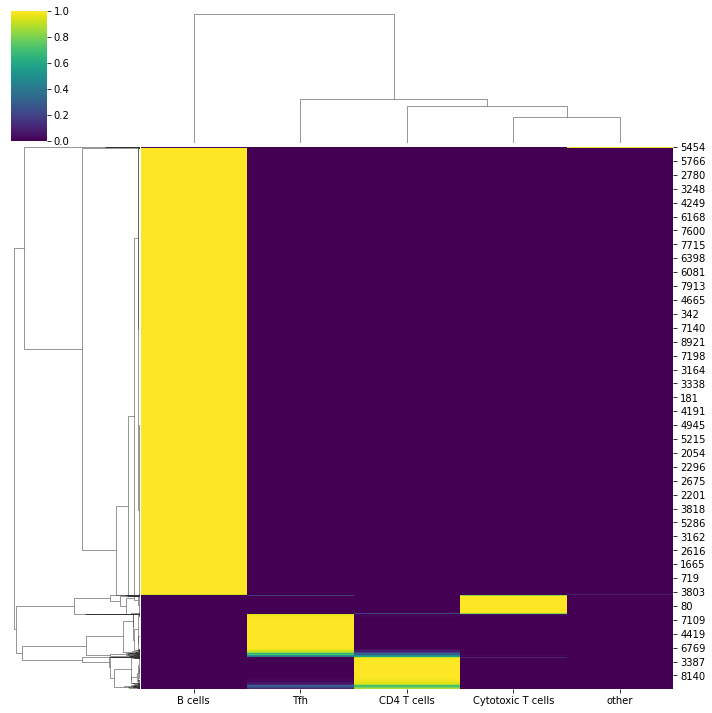

In [16]:
sns.clustermap(predictions, cmap="viridis")

We then create a UMAP plot labeled by maximum probability assignments from the CellAssign model. The left plot contains the true cell types and the right plot contains our model's predictions.

In [17]:
bdata.obs["scvi-tools predictions"] = predictions.idxmax(axis=1).values

/data/yosef2/users/valehvpa/miniconda3/envs/scvi-tools-dev/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'scvi-tools predictions' as categorical


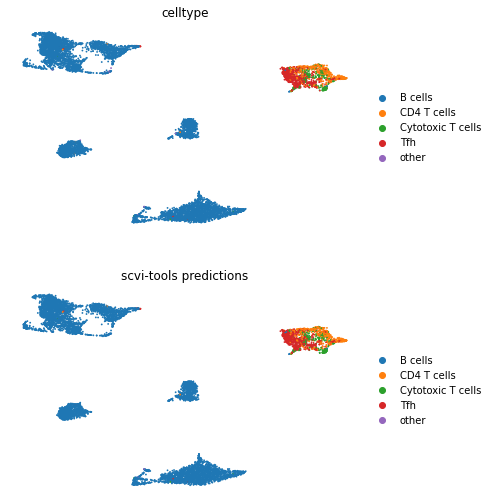

In [18]:
# celltype is the original CellAssign prediction
sc.pl.umap(
    bdata,
    color=["celltype", "scvi-tools predictions"],
    frameon=False,
    ncols=1
)

### Model reproducibility

We see that the scvi-tools implementation highly reproduces the original implementation's predictions.

<AxesSubplot:xlabel='Original predictions', ylabel='scvi-tools predictions'>

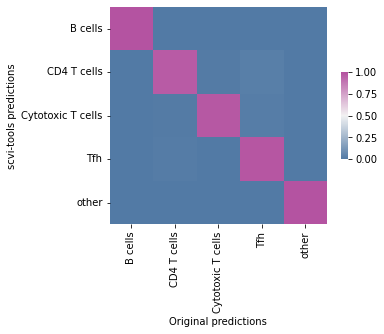

In [19]:
df = bdata.obs
confusion_matrix = pd.crosstab(
    df["scvi-tools predictions"],
    df["celltype"],
    rownames=["scvi-tools predictions"],
    colnames=["Original predictions"],
)
confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(
    confusion_matrix,
    cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
    ax=ax,
    square=True,
    cbar_kws=dict(shrink=0.4, aspect=12),
)

## HGSC Data

We can repeat the same process for HGSC data.

In [20]:
hgsc_adata = scvi.data.read_h5ad("sce_hgsc_annotated_final.h5ad")
hgsc_adata.var_names_make_unique()
hgsc_adata.obs_names_make_unique()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [21]:
marker_gene_mat_hgsc = pd.read_csv('HGSC_celltype.csv', index_col=0)

### Create and fit CellAssign model

In [22]:
hgsc_bdata = hgsc_adata[:, marker_gene_mat_hgsc.index].copy()

In [23]:
scvi.external.CellAssign.setup_anndata(hgsc_bdata, "size_factor")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 4848 cells, 41 vars, 1 batches, 1 
         labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra  
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [24]:
from scvi.external import CellAssign
model_hgsc = CellAssign(hgsc_bdata, marker_gene_mat_hgsc)
model_hgsc.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Epoch 400/400: 100%|█████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:24<00:00, 16.08it/s, loss=40.9, v_num=1]


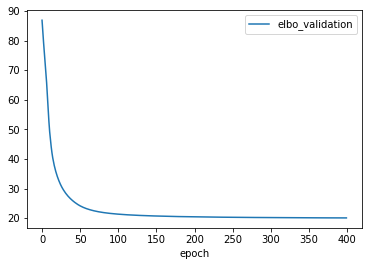

In [26]:
model.history["elbo_validation"].plot()

### Predict and plot assigned cell types

In [27]:
predictions_hgsc = model_hgsc.predict()

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


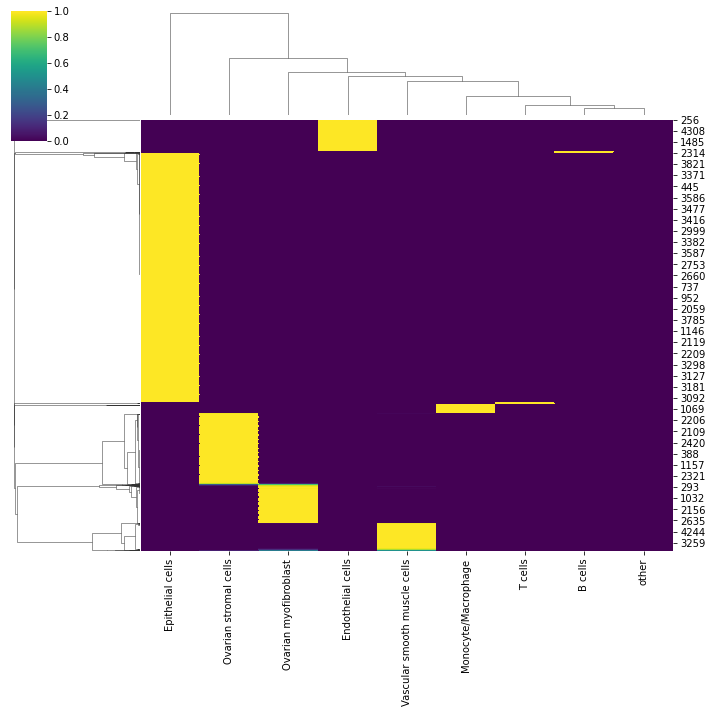

In [28]:
sns.clustermap(predictions_hgsc, cmap="viridis")

In [29]:
hgsc_bdata.obs["scvi-tools predictions"] = predictions_hgsc.idxmax(axis=1).values

... storing 'scvi-tools predictions' as categorical


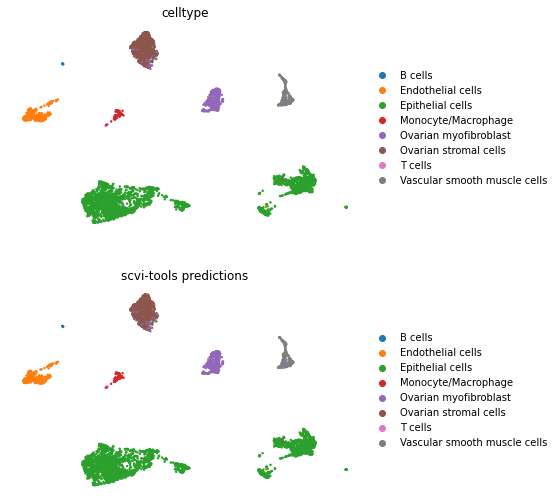

In [30]:
sc.pl.umap(
    hgsc_bdata,
    color=["celltype", "scvi-tools predictions"],
    ncols=1,
    frameon=False,
)

### Model reproducibility

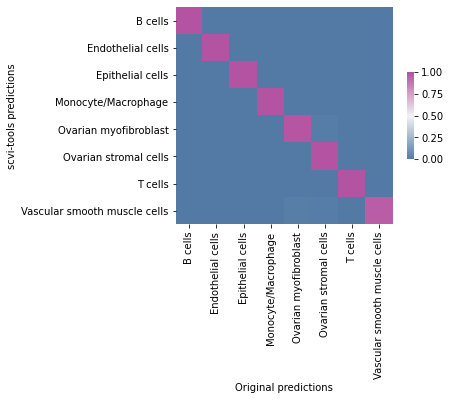

In [38]:
df = hgsc_bdata.obs
confusion_matrix = pd.crosstab(
    df["scvi-tools predictions"],
    df["celltype"],
    rownames=["scvi-tools predictions"],
    colnames=["Original predictions"],
)
confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(
    confusion_matrix,
    cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
    ax=ax,
    square=True,
    cbar_kws=dict(shrink=0.4, aspect=12),
)